In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load data

In [2]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def normalize_data(df):
    norms = df[df.index.get_level_values('temporality')=='normalization'].reset_index('temporality', drop=True)
    adj = norms.unstack(['Protein Gene', 'Protein Accession', 'Peptide Modified Sequence']).apply(lambda x: x/x.mean()).mean(axis=1)
    df_adj = df.groupby(adj.index.names).apply(lambda x: x/adj[x.name])
    
    if 'File Name' in df_adj.index.names:
        df_adj = df_adj.unstack('File Name').mean(axis=1)
    
    return df_adj
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

In [3]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]

In [4]:
folder = r'..\Skyline_reports'
replicate_fmt = 'treatment_timepoint_replicate'
index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name']
data_cols = ['Total Area Fragment']

hsv1_filename = 'HSV-1_baseline.csv'
hsv1 = load_herpesvirusPRMreport(os.path.join(folder, hsv1_filename), 'HSV-1').where(lambda x: x!=0, np.nan).reset_index()
hsv1['virus'] = 'HSV-1'
hsv1= hsv1.set_index(['virus']+index_cols).squeeze() 

hcmv_filename = 'HCMV_baseline.csv'
hcmv = load_herpesvirusPRMreport(os.path.join(folder, hcmv_filename), 'HCMV').where(lambda x: x!=0, np.nan).reset_index()
hcmv['virus'] = 'HCMV'
hcmv= hcmv.set_index(['virus']+index_cols).squeeze() 

kshv_filename = 'KSHV_baseline.csv'
kshv = load_herpesvirusPRMreport(os.path.join(folder, kshv_filename), 'KSHV', replicate_fmt = 'treatment_timepoint_replicate', index_cols = index_cols).where(lambda x: x!=0, np.nan).reset_index()
kshv['virus'] = 'KSHV'
kshv = kshv.set_index(['virus']+index_cols).squeeze()

host = load_herpesvirusPRMreport(os.path.join(folder, 'HSV-1_host_proteins.csv'), 'HSV-1', replicate_fmt = 'treatment_timepoint_replicate', index_cols = index_cols).where(lambda x: x!=0, np.nan).reset_index()
host['virus'] = 'HSV-1'
host = host.set_index(['virus']+index_cols).squeeze()

baseline = pd.concat([hsv1, hcmv, kshv])
filename_mapping = baseline.reset_index()[['virus', 'treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates


# Normalize Data

### MS1 normalization

In [5]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(baseline.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['virus', 'treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['virus', 'treatment', 'replicate']).apply(lambda x: x/x.mean())

baseline_adj = baseline.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)
host_adj = normalize_data(host) # doesn't have SIM MS1 scans, so we use internal normalizing peptides
baseline_adj = pd.concat([host_adj, baseline_adj])

### Mean normalization

In [6]:
cols = ['timepoint']
baseline_norm = mean_normalize(baseline_adj.unstack(cols)).stack(cols)
baseline_avg = baseline_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
baseline_mean = baseline_avg.unstack(['replicate', 'treatment']).mean(axis=1)

### Log2 fold change transformation

In [7]:
avg = baseline_norm.unstack(['Peptide Modified Sequence', 'treatment', 'replicate']).mean(axis=1).unstack('timepoint')
fvi = avg.T.apply(lambda x: x.first_valid_index())
baseline_FC = baseline_norm.unstack('timepoint').groupby(fvi.index.names).apply(lambda x: x.apply(lambda y: y/x[fvi[x.name]].mean())).stack().apply(np.log2).where(lambda x: abs(x)!=np.inf, np.nan)

# Export Supplemental Tables

In [13]:
temp = pd.concat([baseline_FC, baseline_norm], keys = ['log2 FC abundance (relative to 1st detected timepoint)', 'mean-normalized abundance'], names = ['normalization type'])
temp = temp[~temp.index.get_level_values('replicate').isin(['T1', 'T2', 'T3'])]
idx = temp.index.names
temp = temp.reset_index()
temp['rep'] = temp['treatment'].str.cat(temp['replicate'], sep='-').str.replace('DMSO-', '').str.replace('WT-', '')
temp = temp.drop('replicate', axis=1)
temp['replicate'] = temp['rep'].copy()
temp = temp.set_index(idx).drop('rep', axis=1).squeeze()

for v, letter, h in zip(['HSV-1', 'HCMV', 'KSHV'], ['A', 'C', 'D'], ['HPI', 'HPI', 'HPR']):
    
    table = temp.swaplevel(0, 1).sort_index().loc[v].reset_index('treatment', drop=True).unstack(['normalization type', 'timepoint', 'replicate']).T.sort_index().T.sort_index()
    table.columns.names = ['normalization type', 'time point ({})'.format(h), 'replicate']
    
    table.to_csv(r'..\tables\TableS2{}.csv'.format(letter))
    
temp = pd.concat([baseline_FC, baseline_norm], keys = ['log2 FC abundance (relative to 1st detected timepoint)', 'mean-normalized abundance'], names = ['normalization type'])
temp = temp[temp.index.get_level_values('replicate').isin(['T1', 'T2', 'T3'])]
table = temp.swaplevel(0, 1).sort_index().loc['HSV-1'].reset_index('treatment', drop=True).unstack(['normalization type', 'timepoint', 'replicate']).T.sort_index().T.sort_index()
table.columns.names = ['normalization type', 'time point (HPI)', 'replicate']
table.to_csv(r'..\tables\TableS2B.csv')

# Make Figures

### Fig. 2A

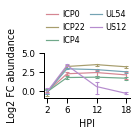

In [15]:
t = 'IE'

fig, ax = plt.subplots(figsize = (2, 2), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HSV-1')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=2, 
      columnspacing=0.0, 
      bbox_to_anchor = (-0.05, 1.02, 1.1, 0.2),
      loc='lower left',
      mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
ax.set_yticks([0, 2.5, 5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


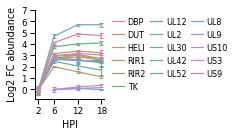

In [17]:
t = 'E'

fig, ax = plt.subplots(figsize = (3.4, 2), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HSV-1')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=3, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
ax.set_yticks(range(8))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


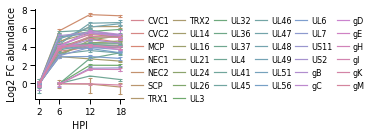

In [19]:
t = 'L'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HSV-1')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=6, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. 2B

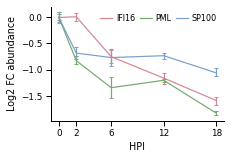

In [21]:
t = 'host'

fig, ax = plt.subplots(figsize = (3.3, 2.3), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HSV-1')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data = data[data['Protein Gene'].isin(['IFI16', 'PML', 'SP100'])]
p = data['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=3, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([0, 2, 6, 12, 18])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2B_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. 2C

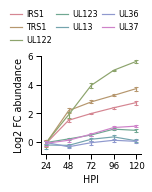

In [22]:
t = 'IE'

fig, ax = plt.subplots(figsize = (2.1, 2.5), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HCMV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels,
      frameon=False,
      framealpha=0,
      ncol=3, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.05),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


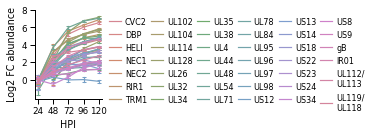

In [24]:
t = 'DE'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HCMV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=6, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.set_yticks([0, 2, 4, 6, 8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


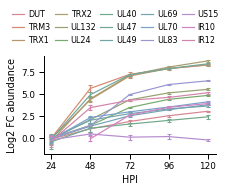

In [26]:
t = 'LL'

fig, ax = plt.subplots(figsize = (3.2, 2.5), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HCMV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.05),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


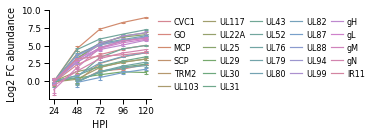

In [28]:
t = 'L'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='HCMV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels,
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.set_yticks([0, 2.5, 5, 7.5, 10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. 2D

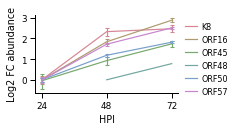

In [30]:
t = 'IE'

fig, ax = plt.subplots(figsize = (3.4, 1.8), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='KSHV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=1, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      loc='upper left',
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


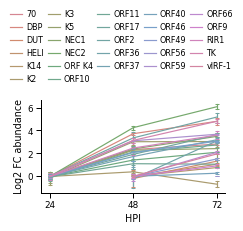

In [32]:
t = 'DE'

fig, ax = plt.subplots(figsize = (3.4, 2.75), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='KSHV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.15),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


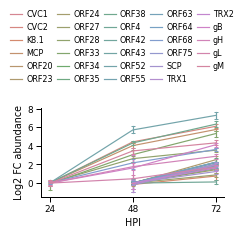

In [34]:
t = 'L'

fig, ax = plt.subplots(figsize = (3.4, 2.75), sharey=True)

data = baseline_FC[(baseline_FC.index.get_level_values('virus')=='KSHV')&(baseline_FC.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.17),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('Log2 FC abundance')

fig.tight_layout()
fig.savefig(r'..\figures\Fig2D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. S5A

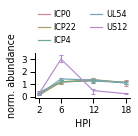

In [16]:
t = 'IE'

fig, ax = plt.subplots(figsize = (2, 2), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HSV-1')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=2, 
      columnspacing=0.0, 
      bbox_to_anchor = (-0.05, 1.02, 1.1, 0.2),
      loc='lower left',
      mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
ax.set_yticks([0, 1, 2, 3])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


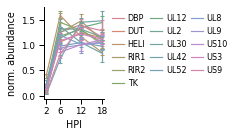

In [18]:
t = 'E'

fig, ax = plt.subplots(figsize = (3.4, 2), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HSV-1')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=3, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
# ax.set_yticks([0, 1, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


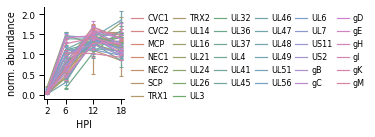

In [20]:
t = 'L'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HSV-1')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax
            )

handles, labels = ax.get_legend_handles_labels()
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=6, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([2, 6, 12, 18])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5A_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. S5B

In [18]:
hsv1_temp = pd.concat([fvi['HSV-1'].groupby(['Protein Gene', 'temporality', 'Protein Accession']).min(), components.reindex(fvi['HSV-1'].groupby(['Protein Gene', 'temporality', 'Protein Accession']).min().index, level='Protein Accession')], axis=1, keys = ['timepoint', 'component']).reset_index().groupby(['temporality', 'timepoint', 'component']).apply(lambda x: x['Protein Gene'].sort_values().str.cat(sep=', '))
hsv1_temp['L'][2]

component
capsid                       CVC1, CVC2, MCP, TRX1, TRX2, UL26, UL6
envelope                         UL45, UL56, gB, gC, gD, gE, gI, gM
non-structural                                           UL24, UL32
tegument          NEC1, NEC2, UL14, UL16, UL21, UL37, UL41, UL46...
dtype: object

### Fig. S5C

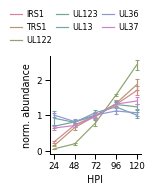

In [23]:
t = 'IE'

fig, ax = plt.subplots(figsize = (2.1, 2.5), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HCMV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels,
      frameon=False,
      framealpha=0,
      ncol=3, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.05),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


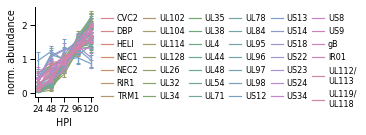

In [25]:
t = 'DE'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HCMV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=6, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


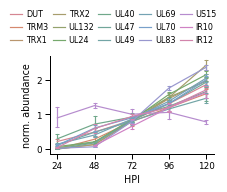

In [27]:
t = 'LL'

fig, ax = plt.subplots(figsize = (3.2, 2.5), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HCMV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.05),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


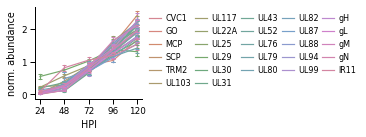

In [29]:
t = 'L'

fig, ax = plt.subplots(figsize = (5.3, 2), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='HCMV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene']= data['Protein Gene'].str.split('|').apply(lambda x: x[-1]).str.replace('_HCMVA', '')
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels,
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      #loc=2,
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72, 96, 120])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5C_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


### Fig. S5D

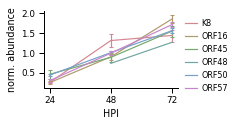

In [31]:
t = 'IE'

fig, ax = plt.subplots(figsize = (3.4, 1.8), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='KSHV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=1, 
      columnspacing=.5, 
      bbox_to_anchor = (1, 1, 0, 0),
      loc='upper left',
#       mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


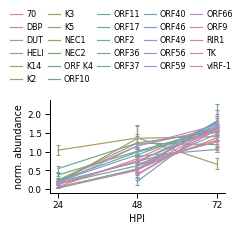

In [33]:
t = 'DE'

fig, ax = plt.subplots(figsize = (3.4, 2.75), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='KSHV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.15),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()


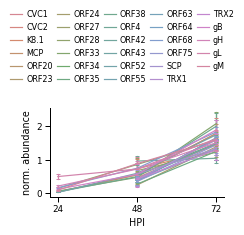

In [35]:
t = 'L'

fig, ax = plt.subplots(figsize = (3.4, 2.75), sharey=True)

data = baseline_norm[(baseline_norm.index.get_level_values('virus')=='KSHV')&(baseline_norm.index.get_level_values('temporality')==t)].reset_index()
data['Protein Gene'] = data['Protein Gene'].where(~data['Protein Gene'].str.contains('/'), data['Protein Gene'].str.replace('/', '/\n'))

p = data.reset_index()['Protein Gene'].unique()

pal_ = sns.husl_palette(p.shape[0], s=.5, l=0.65)

sns.lineplot(data=data, x='timepoint', y=0, 
             hue='Protein Gene',
             err_style='bars', 
             err_kws = {'capsize': 2},
             palette=pal_, ax=ax,
             hue_order = [i for i in p if not '/' in i]+[i for i in p if '/' in i]
            )

handles, labels = ax.get_legend_handles_labels()
      
if len(labels)>len(p):
    handles = handles[1:]
    labels = labels[1:]
      
ax.legend(handles, labels, 
      frameon=False,
      framealpha=0,
      ncol=5, 
      columnspacing=.5, 
      bbox_to_anchor = (0,1.02, 1, 0.17),
      loc='upper left',
     # mode='expand', 
      fontsize=8, 
      handletextpad=0.5, 
      handlelength=1.5,
      bbox_transform = fig.transFigure
     )

ax.set_xticks([24, 48, 72])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('HPI')
ax.set_ylabel('')
ax.set_ylabel('norm. abundance')

fig.tight_layout()
fig.savefig(r'..\figures\FigS5D_{}.png'.format(t), dpi=1000, bbox_inches='tight')
plt.show()
